In [1]:
from ChemRL import *
from stable_baselines3 import PPO
from IPython.display import display
Display = lambda x: display(Chem.Draw.MolToImage(x))
from matplotlib import pyplot as plt

/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

# Load env and agent

In [2]:
env = ChemRlEnv(goal=True, reward_metric="sim")

In [19]:
agent = PPO("MlpPolicy", env, verbose=1)
agent.__class__.load("models/ppo-gcrl-1-2-3-with-shortened-episode-len-ts=5000000-metric=sim/checkpoint_3000000_steps")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Reset episode and create a target

state


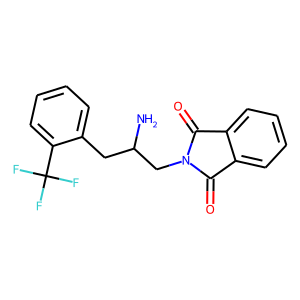

Applicable actions: (10, 8)
(10, 8)
Reaction for target generation


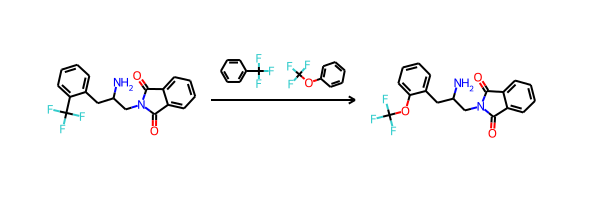

In [48]:
env.reset()

print("state")
Display(env.state)

print("Applicable actions:", get_applicable_actions(env.state).shape)

# Create a target 
action_list = []
state_list = [env.state]
reactions = []

for i in range(1):
    actions = get_applicable_actions(state_list[-1])
    print(actions.shape)
    
    action_list.append(actions.sample().iloc[0])
    state_list.append(apply_action(state_list[-1], *action_list[-1]))
    
    reactant = Chem.MolToSmiles(state_list[-2])
    rsig = smiles_without_atom_index(action_list[-1][2])
    psig = smiles_without_atom_index(action_list[-1][6])
    product = Chem.MolToSmiles(state_list[-1])
    reactions.append(AllChem.ReactionFromSmarts(f'{reactant}>{rsig}.{psig}>{product}',useSmiles=True))

reaction_images = [Draw.ReactionToImage(rxn) for rxn in reactions]
im = get_concat_v_multi_resize(reaction_images)

print("Reaction for target generation")
im

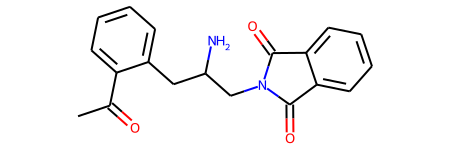

In [62]:
x = state_list[0]
y = apply_action(x, *actions.iloc[9])
y

In [60]:
from rdkit.Chem import AllChem

In [83]:
r = 3
print(AllChem.GetMorganFingerprintAsBitVect(x, r, useChirality=False).ToBinary())
print(AllChem.GetMorganFingerprintAsBitVect(y, r, nBits=2048, useChirality=False).ToBinary())
print(AllChem.GetMorganFingerprintAsBitVect(state_list[-1], r, useChirality=False).ToBinary())

b'\xe0\xff\xff\xff\x00\x08\x00\x002\x00\x00\x00\x02l,\x00B\x9c\x88fJ\x84\x82\xb6\x14j\x0e X\x92,\x8aF&&8hd\xa46\xf0\x00\x10$<\x02\x10"V\x041\x00\x02$\xaaZP\xa2\\\x02\x02\x06\n\xe2'
b'\xe0\xff\xff\xff\x00\x08\x00\x003\x00\x00\x00\x02l,\x00\xe0\xf0J\xad\x01\x00h\x0e b\x88(\x8en&8@&&<\xa46R\x08^2\x00*\n<\x14"J\xf26\x02$\r\x00P8hV\x04\x02\x16V\x180>'
b'\xe0\xff\xff\xff\x00\x08\x00\x005\x00\x00\x00\x02l,\x00B\x9cn\x80Jj5\x00Nj\x0e 6XZ\xb8\x08$\x02:&8hdx*6"\xcc\x00\x1c\x18<\x14"\x00T=\x00\x02\n\x18\r\x00P\xa2\\\x02\n\nF|\x1c'


In [ ]:
fp.

# testing

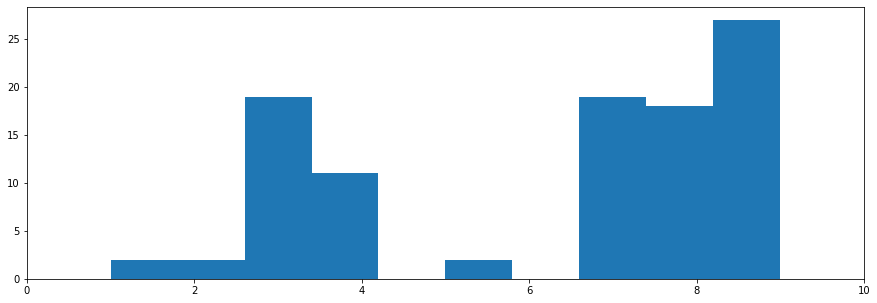

Correct action: 1
top 10 =  (9, 7, 3, 8, 4, 5, 2, 1)


In [49]:
timestep = 0

hash_to_embedding_map = pickle.load(open(os.path.join(MAIN_DIR, "datasets/my_uspto/action_embeddings.pickle"), 'rb'))

hash_indices = get_applicable_actions(state_list[timestep]).index 
embedding_list = np.array([hash_to_embedding_map[hash] for hash in hash_indices])

l = [agent.predict(np.append(env._state_embedding(state_list[0]), env._state_embedding(state_list[-1])))[0] for i in range(100)]

action_indices = []
for act in l:
    distance = ((embedding_list-act)**2).sum(axis=1) # sqrt doesnt change argmin
    choice = distance.argmin()
    action_indices.append(choice)

plt.figure(figsize=(15,5))
plt.hist(action_indices, bins=hash_indices.shape[0])
plt.xlim(0, hash_indices.shape[0])
plt.show()


print("Correct action:", (hash_indices == action_list[timestep].name).argmax())

x = np.unique(action_indices, return_counts=True)
y = list(zip(x[1], x[0]))
y.sort(reverse=True)
print("top 10 = ", list(zip(*y))[1][:10])